In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PLantVillage/potato",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

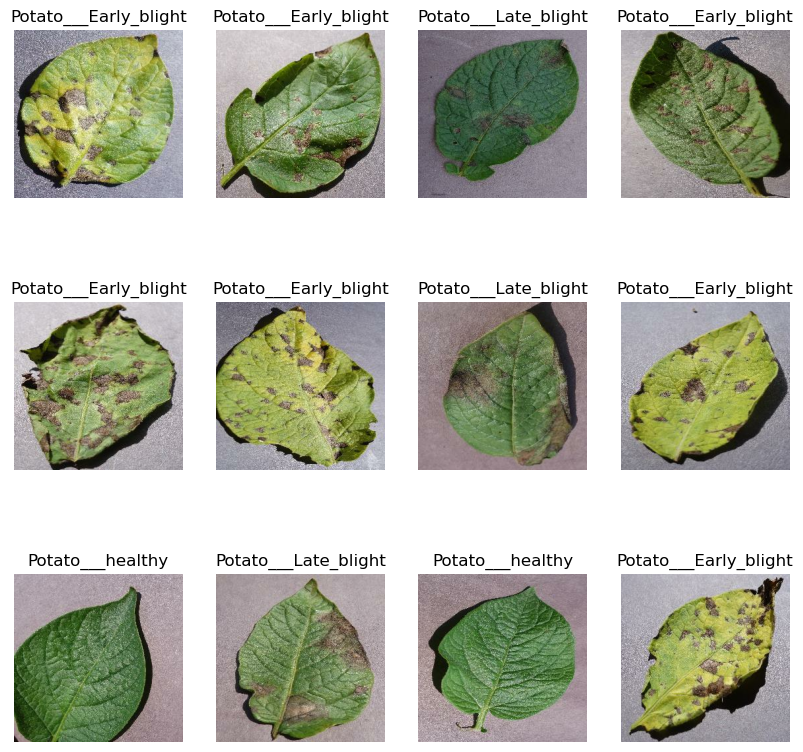

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000, seed = 2):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = seed)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax')
])
model.build(input_shape = input_shape)

C:\Users\syeds\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 524ms/step - accuracy: 0.4554 - loss: 0.9460 - val_accuracy: 0.4948 - val_loss: 0.8665
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 542ms/step - accuracy: 0.5429 - loss: 0.8363 - val_accuracy: 0.6615 - val_loss: 0.6805
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.7304 - loss: 0.6130 - val_accuracy: 0.6406 - val_loss: 0.8372
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ -10771s -203239869us/step - accuracy: 0.7685 - loss: 0.4927 - val_accuracy: 0.8177 - val_loss: 0.4084
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.8246 - loss: 0.4148 - val_accuracy: 0.8594 - val_loss: 0.3482
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 521ms/step - accuracy: 0.8895 - loss: 0.2549 - val_accuracy: 0.8958 - val_loss: 0.2834
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.9232 - loss: 0.2058 - val_accuracy: 0.8958 - val_loss: 0.2428
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 513ms/step - accuracy: 0.8785 - loss: 0.2570

In [15]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9800 - loss: 0.0541


[0.05403384566307068, 0.9765625]

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

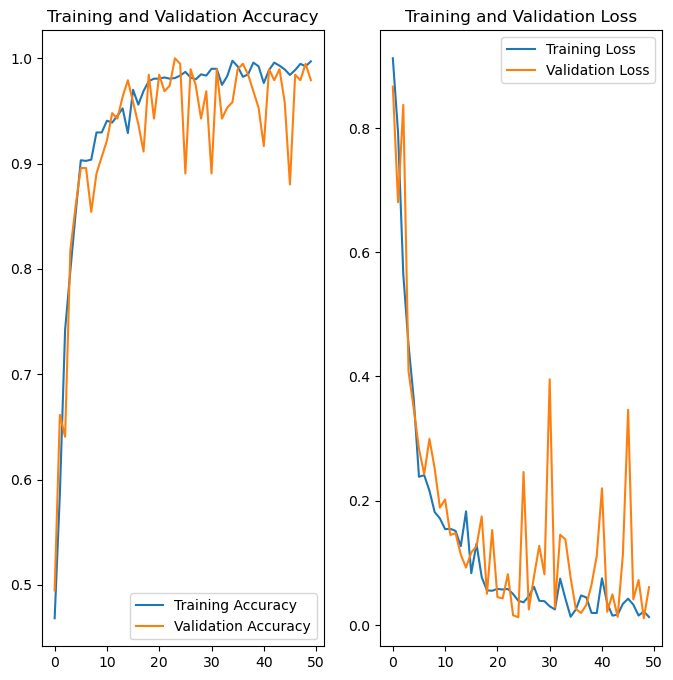

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


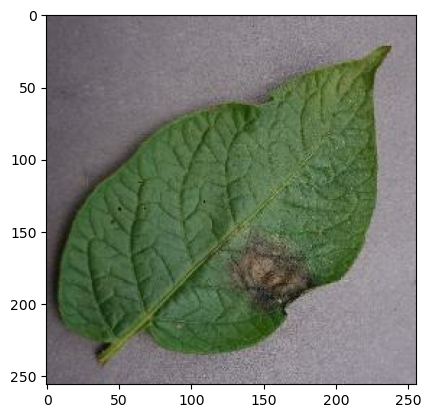

In [18]:
for image_batch, label_batch in test_ds.take(1):
    image = image_batch[0].numpy().astype('uint8')
    label = label_batch[0].numpy()
    
    predicted_batch = model.predict(image_batch)
    predicted_label = class_names[np.argmax(predicted_batch[0])]
    
    print("actual label:", class_names[label])
    print("predicted label:", predicted_label)
    plt.imshow(image)
    

In [26]:
model_version = max([int(i) for i in os.listdir("../models")+[0]])+1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2895843504576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843504752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843506336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843507568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843507216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843507040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843506864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895843506512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895881864112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895881864464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2895881863936: TensorSpec(shape=(), dty

In [30]:
model.save("../potatoes.h5")

TypeError: cannot pickle 'module' object

In [2]:
pip install tensorflow

     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     -------------------------- ------------- 30.7/46.2 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 461.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 0.1/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 0.1/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 0.2/377.0 MB 1.4 MB/s eta 0:04:34
   ---------------------------------------- 0.3/377.0 MB 1.6 MB/s eta 0:04:00
   ---------------------------------------- 0.4/377.0 MB 1.6 MB/s eta 0:03:53
   ---------------------------------------- 0.7/377.0 MB 2.7 MB/s eta 0:02:20
   ---------------------------------------- 1.1/377.0 MB 3.6 MB/s eta 0:01:45
   ---------------------------------------- 1.5/377.0 MB 4.3 MB/s eta 0:0